# CS156 Assignment 5
## PCA & LDA for Classifying EigenFashion 
### Tomer Eldor
#### Minerva Schools
*Text Analysis is after each corresponding code block, and complete longer analysis of results is at the end.*

In [31]:
# original code reference: (By Joel Grus, author of the blog mentioned in the preclass-work)
# adapted from https://github.com/joelgrus/shirts/blob/master

### Setup ###
from PIL import Image
import PIL.ImageOps

from collections import defaultdict
from glob import glob
from random import shuffle, seed
import numpy as np
import pylab as pl
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn import metrics #, linear_model,
from sklearn.decomposition import RandomizedPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
%matplotlib inline


In [9]:
# Fetching Files (globbing them)
girls_files = glob('/Users/tomereldor/PycharmProjects/CS156ML/PCA/women/womensample/*')
boys_files = glob('/Users/tomereldor/PycharmProjects/CS156ML/PCA/men/mensample/*')

# STANDARTIZE SIZE and SHAPE 
STANDARD_SIZE = (138,138) #most common size found in the dataset
HALF_SIZE = (STANDARD_SIZE[0]/2,STANDARD_SIZE[1]/2)

def img_to_array(filename):
    # takes a filename and turns it into a numpy array of RGB pixels
    img = Image.open(filename)
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.asarray(img) # np.asarray() will extricate the RGB channels from each pixel in the original image),
    s = img.shape[0] * img.shape[1] #size
    img_wide = img.reshape(1, s) #reshaping 
    # Image.close() 
    return img_wide[0]

# Processing files: converting Image to Numpy RGB arrays
raw_data = [(img_to_array(filename),'girl',filename) for filename in girls_files] + \
           [(img_to_array(filename),'boy',filename) for filename in boys_files]

## print(raw_data[:10]) #debug

# shuffle the data ('randomly', though I'm seeding for replicating results)
seed(0)
shuffle(raw_data)

# pull out the features and the labels
data = np.array([cd for (cd,_y,f) in raw_data])
labels = np.array([_y for (cd,_y,f) in raw_data])


#### Splitting the dataset from the into 80% training data and 20% testing data.

In [10]:
train_split = int(0.8*len(data)) 
#splitting: 
X_train , X_test = data[:train_split] , data[train_split:] 
y_train , y_test = labels[:train_split] , labels[train_split:]

#debug / verification:
print("X   Train N: {}, X   Test N: {}".format(len(X_train), len(X_test)))
print("Y   Train N: {}, Y   Test N: {}".format(len(y_train), len(y_test)))

X   Train N: 336, X   Test N: 84
Y   Train N: 336, Y   Test N: 84


#### 2) Build a simple linear classifier using the original pixel data. What is your error rate on the training data? What is your error rate on your testing data?
I start with a simple linear model - **Logistic Regression**.
I chose logistic regression since it is simple and good as a starting point, in case it works well. It is useful for me since I'm more familiar with it and wanted to see how well it would perform in this case. 

In [44]:
## LOGISTIC REGRESSION
# fitting the model
clf_log =  LogisticRegression(penalty='l2')  # sepcifying penalty (regularization term) of L2, with a dual formulation only for the L2 penalty.
clf_log.fit(X_train, y_train)

# TRAIN set prediction and accuracy
print "Logistic Regression: Trainig set (no reduction)"
predicted_train_log = clf_log.predict(X_train)
score_log_train = clf_log.score(X_train, y_train)
print "\nAccuracy Score on test set: %.3f" % score_log_train
print(metrics.confusion_matrix(y_train, predicted_train_log))
print "\nClassification report on test set"
print(metrics.classification_report(y_train, predicted_train_log))
print "____________________________________________________"

# TEST set prediction and accuracy
print "\nLogistic Regression: TEST set (no reduction)"
predicted_test_log = clf_log.predict(X_test)
score_log_test = clf_log.score(X_test, y_test)
print "Accuracy Score on test set: %.3f" % score_log_test
print "\nConfusion Matrix on test set: "
print(metrics.confusion_matrix(y_test, predicted_test_log))
print "\nClassification report on test set"
print(metrics.classification_report(y_test, predicted_test_log))

Logistic Regression: Trainig set (no reduction)

Accuracy Score on test set: 1.000
[[173   0]
 [  0 163]]

Classification report on test set
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       173
          1       1.00      1.00      1.00       163

avg / total       1.00      1.00      1.00       336

____________________________________________________

Logistic Regression: TEST set (no reduction)
Accuracy Score on test set: 0.631

Confusion Matrix on test set: 
[[27 10]
 [21 26]]

Classification report on test set
             precision    recall  f1-score   support

          0       0.56      0.73      0.64        37
          1       0.72      0.55      0.63        47

avg / total       0.65      0.63      0.63        84



Logistic Regression with no dimensionality regression performs reasonably but unimpressively, with 0.63 accuracy score overall on the test set. Conversely, we have perfect 1.00 accuracy on the training set, but that isn't surprising and is even not a very good sign since it means that our model is overfitting on the data - what logistic regression can often result with...
Also, we see there is some imbalance with the precision-recall per class - the model performs with much higher precision for boys (0.72 vs 0.56) while exhibiting the opposite trend - much higher recall for girls (0.55 vs 0.73). That shows us the model is not balanced in determining male/female; according to the confusion matrix, we see it predicts significantly more false positives. Theoretically, since this is a logistic regression, in this case of too many false positives, we could try adjusting the cutoff value to classify as positive to be slightly higher and see if our accuracy improves.
Additionally, I don't think this is the ideal case to use logistic regression since I usually work with logistic regressions when I want to manually insert the features, having an idea of which features or combinations of features should make sense (thus not include everything). However, in this image recognition, the model is left with inspecting all the raw pixel colors data and make sense of it itself. 
That's why reducing dimensionality should visibly improve logistic regression.
Therefore, I wanted to try another kind of model - SVC linear classifier - and see if it performs better on the test set.


In [45]:
#LINEAR SVC MODEL
# from sklearn.svm import LinearSVC

# fitting the model
clf_svc =  LinearSVC(random_state = 42) #(if we give it the answer to the question about the meaning of life and everything as a random seed it might perform better since it knows already the answer to everything)
clf_svc.fit(X_train, y_train)

# Train set prediction and accuracy
print "\nLinear SVC Classifier, TRAINING Set (no reduction)"
predicted_train_svc = clf_svc.predict(X_train)
score_svc_train = clf_svc.score(X_train, y_train)
print "Accuracy Score on training set: %.3f" % score_svc_train
print "\nConfusion Matrix on test set: "
print(metrics.confusion_matrix(y_train, predicted_train_svc))
print "\nClassification report on test set"
print(metrics.classification_report(y_train, predicted_train_svc))
print "____________________________________________________"

# Test set prediction and accuracy
predicted_test_svc = clf_svc.predict(X_test)
score_svc_test = clf_svc.score(X_test,y_test)
print "\nLinear SVC Classifier, TEST SET (no reduction)"
print "Accuracy Score on test set: %.3f" % score_svc_test
print "\nConfusion Matrix on test set: "
print(metrics.confusion_matrix(y_test, predicted_test_svc))
print "\nClassification report on test set"
print(metrics.classification_report(y_test, predicted_test_svc))


Linear SVC Classifier, TRAINING Set (no reduction)
Accuracy Score on training set: 1.000

Confusion Matrix on test set: 
[[173   0]
 [  0 163]]

Classification report on test set
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       173
          1       1.00      1.00      1.00       163

avg / total       1.00      1.00      1.00       336

____________________________________________________

Linear SVC Classifier, TEST SET (no reduction)
Accuracy Score on test set: 0.631

Confusion Matrix on test set: 
[[28  9]
 [22 25]]

Classification report on test set
             precision    recall  f1-score   support

          0       0.56      0.76      0.64        37
          1       0.74      0.53      0.62        47

avg / total       0.66      0.63      0.63        84



After running a linear SVC classifier on the (non-reduced) data, the model did a fair but unimpressive job predicting on the test set, with an accuracy of 0.631. Similarly, it does predict with perfect 1.00 accuracy on the training set, but that just means overfitting, and we should not be too happy about this. This explains the major differences between 1.00 accuracy on the training set to 0.63 accuracies on the test set. This also exhibits the same trend of predicting too many false positives over false negatives and thus creates an imbalanced prediction.


Also, I'm not using many samples - only 200 in the first trials; while we have many many features for the models to include. Thus there might be more features than observations, which is bad for the model. Because of the curse of dimensionality, this makes it harder for the model to find the correct costs/distances/what features to use and how to correctly classify, having so many features but few samples.


Perhaps SVC with a nonlinear kernel, such as RBF SVM, would have been more flexible and improved accuracy.

# Modeling with PCA and LDA
Below I create both PCA and LDA principal components for dimensionality reductions parallelly (as it's more concise), then train the same model as before on PCA data and LDA data and compare results.


In [54]:

### PCA! - find the principal components
pca = RandomizedPCA(n_components=70, random_state=0)
X_PCA = pca.fit_transform(data)
y = [1 if label == 'boy' else 0 for label in labels]

### LDA! - find the LDA reduced dimensions
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=15)
#X_LDA = lda.fit(X_PCA, y).transform(X_PCA)
X_LDA = lda.fit_transform(data,y)

# Percentage of variance explained for each component
pca_var_ratios = pca.explained_variance_ratio_
lda_var_ratios = lda.explained_variance_ratio_


/Users/tomereldor/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


### Choosing number of components for LDA and PCA

In [55]:
# CHOOSING THE NUMBER OF COMPONENTS TO USE IN EITHER PCA AND LDA!
# For that, we will compute when the total variance explained is higher than 0.99
def select_n_components(var_ratio, goal_var):
        total_variance = 0.0 # set initial variance explained
        n_components = 0     # set initial number of features
        components = []
        var_inc = []
        var_total = []
        # For the explained variance of each feature:
        for explained_variance in var_ratio:
            # Add the explained variance to the total
            total_variance += explained_variance
            # Add one to the number of components
            n_components += 1
            # If we reach our goal level of explained variance
            print "component %d adds %.4f to variance, now total variance is %.4f" % (n_components, explained_variance, total_variance)
            #results.append([n_components, explained_variance, total_variance])
            components.append(n_components)
            var_inc.append(explained_variance)
            var_total.append(total_variance)
            if total_variance >= goal_var:
                break     # End the loop if we reached our goal variance explained
        return n_components, components,var_inc,var_total   # Return the number of components

print "PCA Dimensions: "
pca_n_components, pca_components_ids, pca_var_inc, pca_var_total = select_n_components(pca_var_ratios, 0.95)
print "PCA components selected: ", pca_n_components


PCA Dimensions: 
component 1 adds 0.3223 to variance, now total variance is 0.3223
component 2 adds 0.1032 to variance, now total variance is 0.4254
component 3 adds 0.0459 to variance, now total variance is 0.4713
component 4 adds 0.0329 to variance, now total variance is 0.5042
component 5 adds 0.0288 to variance, now total variance is 0.5330
component 6 adds 0.0253 to variance, now total variance is 0.5583
component 7 adds 0.0196 to variance, now total variance is 0.5779
component 8 adds 0.0158 to variance, now total variance is 0.5937
component 9 adds 0.0143 to variance, now total variance is 0.6080
component 10 adds 0.0116 to variance, now total variance is 0.6196
component 11 adds 0.0112 to variance, now total variance is 0.6308
component 12 adds 0.0103 to variance, now total variance is 0.6411
component 13 adds 0.0092 to variance, now total variance is 0.6503
component 14 adds 0.0082 to variance, now total variance is 0.6585
component 15 adds 0.0074 to variance, now total varian

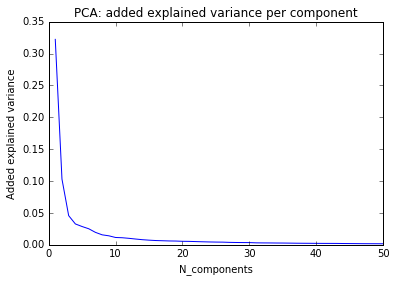

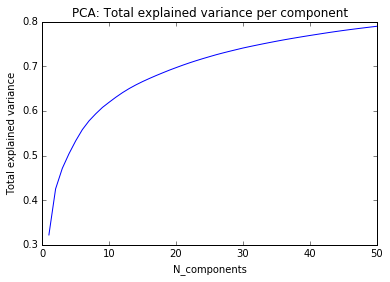

In [60]:
## PLOTTING Components Explained Variance
def plot_variance(pca_components_ids,pca_var_inc,pca_var_total):
    %matplotlib inline

    plt.plot(pca_components_ids, pca_var_inc)
    plt.title("PCA: added explained variance per component")
    plt.xlabel('N_components')
    plt.ylabel('Added explained variance')
    plt.show()

    #plt.plot(x, y)

    plt.plot(pca_components_ids, pca_var_total)
    plt.title("PCA: Total explained variance per component")
    plt.xlabel('N_components')
    plt.ylabel('Total explained variance')
    plt.show()

plot_variance(pca_components_ids,pca_var_inc,pca_var_total)

#### Choosing number of components for LDA and PCA
This analysis suggests that the more PCA components there are, the more variance we explain, but we do aim to minimize the number of components use. So I would choose about 50 PCA components - where the additional explained variance drops below 0.002 and it remains the same 4 decimals for 4 iterations (or 3 iterations afterward). With PCA, the explained variance keeps improving as we add components, so at 50 components, the variance explained is fair, ~0.79, and the marginal utility of adding another PCA component is flattened and doesn't contribute significantly anymore. We can see that with the text output as well as from the second plot of Total Explained Variance, bring after the convex point and going flatter and flatter, and from the incremental value added plot seeing it's close to 0 and pretty flat at least from components 35 or 40. We could, of course, continue adding components, but the whole goal of dimensionality reduction is to simplify with much FEWER components than the original data, so we don't want to over-add components.

However, for LDA there is only a maximum of 1 component to choose in this case. It can't give us the same kind of measure of variance explained. The maximum number of dimensions for LDA, in this case, is #of classes-1, which would be (2 classes - 1) = 1 dimension maximum anyway. Therefore we can't optimize the number of LDA dimensions to choose.
Let's see how good will LDA will perform with one class.


/Users/tomereldor/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


PCA Dimensions: 
component 1 adds 0.3223 to variance, now total variance is 0.3223
component 2 adds 0.1032 to variance, now total variance is 0.4254
component 3 adds 0.0459 to variance, now total variance is 0.4713
component 4 adds 0.0329 to variance, now total variance is 0.5042
component 5 adds 0.0288 to variance, now total variance is 0.5330
component 6 adds 0.0253 to variance, now total variance is 0.5583
component 7 adds 0.0196 to variance, now total variance is 0.5779
component 8 adds 0.0158 to variance, now total variance is 0.5937
component 9 adds 0.0143 to variance, now total variance is 0.6080
component 10 adds 0.0116 to variance, now total variance is 0.6196
component 11 adds 0.0112 to variance, now total variance is 0.6308
component 12 adds 0.0103 to variance, now total variance is 0.6411
component 13 adds 0.0092 to variance, now total variance is 0.6503
component 14 adds 0.0082 to variance, now total variance is 0.6585
component 15 adds 0.0074 to variance, now total varian

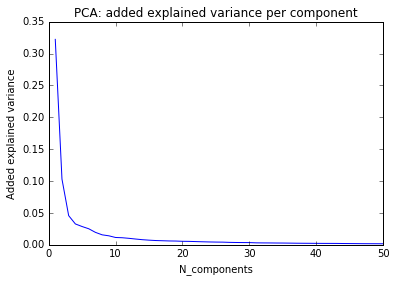

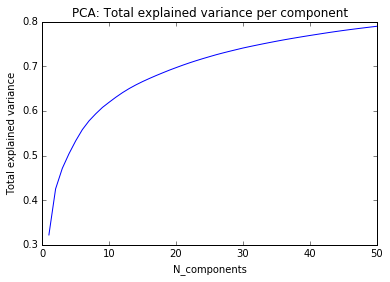

In [61]:
### PCA! - find the principal components, now with selected 50 components
pca = RandomizedPCA(n_components=50, random_state=0)
X_PCA = pca.fit_transform(data)
pca_var_ratios = pca.explained_variance_ratio_

print "PCA Dimensions: "
pca_n_components, pca_components_ids, pca_var_inc, pca_var_total = select_n_components(pca_var_ratios, 0.95)
print "PCA components selected: ", pca_n_components
plot_variance(pca_components_ids,pca_var_inc,pca_var_total)


### PREDICTIVE MODELING AND RESULTS
#### Prep: splitting into train and test

In [46]:
# PREDICTIVE MODELING

# split the data into a training set and a test set; since the photos are randomly shuffled, we can just split by order.
# determine split cutoff 80% training data, 20% test data
train_split = int(0.8*len(data)) 
#splitting: 
X_PCA_train , X_PCA_test = X_PCA[:train_split] , X_PCA[train_split:] 
X_LDA_train , X_LDA_test = X_LDA[:train_split] , X_LDA[train_split:] 
y_train , y_test = y[:train_split] , y[train_split:]
# for debug:
print("PCA Train N: {}, PCA Test N: {}".format(len(X_PCA_train), len(X_PCA_test)))
print("PCA Train N: {}, PCA Test N: {}".format(len(X_LDA_train), len(X_LDA_test)))
print("Y   Train N: {}, Y   Test N: {}".format(len(y_train), len(y_test)))



PCA Train N: 336, PCA Test N: 84
PCA Train N: 336, PCA Test N: 84
Y   Train N: 336, Y   Test N: 84


### PCA & LDA on Logistic Regression

In [51]:
# CHOOSE AND FIT CLASSIFIER MODEL
print "*** Logistic Regression ***\n"
#over PCA Data
print "PCA: Logistic Regression"
clf_pca = LogisticRegression(penalty='l2')
clf_pca.fit(X_PCA_train,y_train)
print "Accuracy score PCA Classifier, training set: ",clf_pca.score(X_PCA_train,y_train)
print "Accuracy score PCA Classifier, test set: ",clf_pca.score(X_PCA_test,y_test)
predicted_pca_log = clf_pca.predict(X_PCA_test)
print "\nConfusion Matrix on test set: "
print(metrics.confusion_matrix(y_test, predicted_pca_log))
print "\nClassification report on test set"
print(metrics.classification_report(y_test, predicted_pca_log))

#over LDA Data
print "\nLDA: Logistic Regression"
clf_lda_log = LogisticRegression(penalty='l2')
clf_lda_log.fit(X_LDA_train,y_train)
print "Accuracy score LDA Classifier, training set: ",clf_lda_log.score(X_LDA_train,y_train)
print "Accuracy score LDA Classifier, test set: "  ,  clf_lda_log.score(X_LDA_test,y_test)
predicted_lda_log = clf_lda_log.predict(X_LDA_test)
print "\nConfusion Matrix on test set: "
print(metrics.confusion_matrix(y_test, predicted_lda_log))
print "\nClassification report on test set"
print(metrics.classification_report(y_test, predicted_lda_log))

*** Logistic Regression ***

PCA: Logistic Regression
Accuracy score PCA Classifier, training set:  0.741071428571
Accuracy score PCA Classifier, test set:  0.654761904762

Confusion Matrix on test set: 
[[27 10]
 [19 28]]

Classification report on test set
             precision    recall  f1-score   support

          0       0.59      0.73      0.65        37
          1       0.74      0.60      0.66        47

avg / total       0.67      0.65      0.66        84


LDA: Logistic Regression
Accuracy score LDA Classifier, training set:  0.925595238095
Accuracy score LDA Classifier, test set:  0.892857142857

Confusion Matrix on test set: 
[[33  4]
 [ 5 42]]

Classification report on test set
             precision    recall  f1-score   support

          0       0.87      0.89      0.88        37
          1       0.91      0.89      0.90        47

avg / total       0.89      0.89      0.89        84



### PCA and LDA on SVC Model

In [50]:
# CHOOSE AND FIT CLASSIFIER MODEL
clf_svc =  LinearSVC(random_state = 42) #(if we give it the answer to the question about the meaning of life and everything as a random seed it might perform better since it knows already the answer to everything)
clf_svc.fit(X_train, y_train)

print "*** SVC MODEL ***\n"

#over PCA Data
print "PCA: SVC Model"
clf_pca_svc = LinearSVC(random_state = 42)
clf_pca_svc.fit(X_PCA_train,y_train)
print "Accuracy score PCA Classifier, training set: ",clf_pca_svc.score(X_PCA_train,y_train)
print "Accuracy score PCA Classifier, test set: ",clf_pca_svc.score(X_PCA_test,y_test)
predicted_pca_svc = clf_pca_svc.predict(X_PCA_test)
print "\nConfusion Matrix on test set: "
print(metrics.confusion_matrix(y_test, predicted_pca_svc))
print "\nClassification report on test set"
print(metrics.classification_report(y_test, predicted_pca_svc))

#over LDA Data
print "\nLDA: SVC Model"
clf_lda_svc = LinearSVC(random_state = 42)
clf_lda_svc.fit(X_LDA_train,y_train)
print "Accuracy score LDA Classifier, training set: ",clf_lda_svc.score(X_LDA_train,y_train)
print "Accuracy score LDA Classifier, test set: "  ,  clf_lda_svc.score(X_LDA_test,y_test)
predicted_lda_svc = clf_lda_svc.predict(X_LDA_test)
print "\nConfusion Matrix on test set: "
print(metrics.confusion_matrix(y_test, predicted_lda_svc))
print "\nClassification report on test set"
print(metrics.classification_report(y_test, predicted_lda_svc))

*** SVC MODEL ***

PCA: SVC Model
Accuracy score PCA Classifier, training set:  0.613095238095
Accuracy score PCA Classifier, test set:  0.535714285714

Confusion Matrix on test set: 
[[20 17]
 [22 25]]

Classification report on test set
             precision    recall  f1-score   support

          0       0.48      0.54      0.51        37
          1       0.60      0.53      0.56        47

avg / total       0.54      0.54      0.54        84


LDA: SVC Model
Accuracy score LDA Classifier, training set:  0.931547619048
Accuracy score LDA Classifier, test set:  0.892857142857

Confusion Matrix on test set: 
[[33  4]
 [ 5 42]]

Classification report on test set
             precision    recall  f1-score   support

          0       0.87      0.89      0.88        37
          1       0.91      0.89      0.90        47

avg / total       0.89      0.89      0.89        84



## ANALYSIS

#### Results and conclusion
The models results showed surprisingly that LDA (although having only one dimension) performed much better than PCA, on both Logistic Regression or SVC classifiers:
LDA data resulted in Accuracy of 0.89 (with either svc or logistic regression)
Whereas PCA data resulted in Accuracy of 0.66 for logistic regression and 0.53 for SVC classifiers.
Therefore, I would choose an LDA reduced dimensionality representation of the data for this problem; however, once choosing it, the choice of the model between logistic regression or linear SVC apparently didn't matter much regarding accuracy of prediction on the test set. However, logistic regression performed better for the PCA fitted data, suggesting that it might do a better job with even more dimensioned data for this particular problem. Also, Logistic regression is a simpler model and can be more easily interpreted, and now that there are no differences in accuracy - I would choose Logistic Regression as a model and LDA as a dimensionality reduction technique.

#### Interpretation
Generally, LDA can indeed be superior, since it is a case of CLASSIFICATION, and LDA is built to find optimal dimensions that maximize the SEPARABILITY of classes, so it directly helps with classification; whereas PCA is merely focuses at preserving as much of the original "information" in the data as possible, but without any relation to the separability or later uses of the data, be it classification or not. Therefore LDA might be better for some classification problems, and it seemed to have performed better for this one, where we only care about classification, and care to preserve nothing more from the data after we classify.
However, I highly doubted this results, since we are classifying into two categories alone. Thus *LDA's maximal number of dimensions was 1, and it used **only one dimension** for the classification*. Thus it's weird that it performed so well.
I have tried to see if there were any bugs or abnormalities have caused that, but found none so far. 
Therefore I'm left with concluding, that if everything was handled correctly indeed, then the LDA simply did a great job at finding a one dimensional representation of the factor that clearly was the key determinant of boys and girls.

Conversely, PCA does seem to perform rather poorly, especially with the SVC classifier. There, the accuracy on the training set is only around 0.61. ** How come it doesn't even classify well on its own training set?**. Also bad were the results on the test set - only about 0.53 accuracy, which is pretty bad - it is *not much better than chance!*. 
Therefore PCA seems not the right path to go, especially not with SVC classifier.

#### Possible problems with the Data 
From looking more closely at the sample of the ~250 shirts I used. It does seem that the majority of male shirts were in darker, bluer colors, where the majority of women's shirts were in lighter, reddish / pinkish hues. Therefore, the LDA might have successfully picked up on that color difference in an efficient *"DarkBlueish to LightRedPinkish"* 1D scale that served as the necessary information. 
Therefore, I would try this on a much larger dataset than the sample of ~250 shirts I used.

Other potential problems with the Data, is that firstly, the classification is sometimes ambiguous and it's a difficult problem because of that. The images are not standardized (not in a uniform format regarding how many clothes per picture, which positioning, which background, etc.). 

From looking at the pictures, there are quite a bit of shirt that *I myself wouldn't know for which gender to classify*.  









# APPENDIX

### More Detailed Results
Presenting model probabilities and scores for each shirt in database, and finding the most extreme values (most "manly" shirts, most "girly" shirts, most ambigious shirts) for debuggin and more detailed look.

In [21]:

# RESULTS METRICS

# First: Here are the Model SCORES for EVERY SHIRT in our dataset
probs_PCA = zip(clf_pca.decision_function(X_PCA),raw_data)
probs_LDA = zip(clf_lda.decision_function(X_LDA),raw_data)

def evaluate_and_find_extremes(model):
    """find most extreme shirts, for either PCA or LDA, as specified in the parameters above"""
    ## get variables for this model:
    if model in ("pca","PCA"):
        probs = probs_PCA
        x_model = X_PCA
        X_test_model = X_PCA_test
        clf_model = clf_pca
    
    elif model in("lda","LDA"):
        probs = probs_LDA
        x_model = X_LDA
        X_test_model = X_LDA_test
        clf_model = clf_lda
        
    else:
        raise ValueError("please enter either 'PCA' or 'LDA', with quotes, like this: extreme_shirts('PCA') ")
        
    girliest_girl_shirt = sorted(probs,key=lambda (p,(cd,g,f)): (0 if g == 'girl' else 1,p))[0]
    girliest_boy_shirt = sorted(probs,key=lambda (p,(cd,g,f)): (0 if g == 'boy' else 1,p))[0]
    boyiest_girl_shirt = sorted(probs,key=lambda (p,(cd,g,f)): (0 if g == 'girl' else 1,-p))[0]
    boyiest_boy_shirt = sorted(probs,key=lambda (p,(cd,g,f)): (0 if g == 'boy' else 1,-p))[0]
    most_androgynous_shirt = sorted(probs,key=lambda (p,(cd,g,f)): abs(p))[0]

    # and let's look at the most and least extreme shirts
    cd = zip( x_model ,raw_data) #the x specified from the function: either of PCA or LDA
    least_extreme_shirt = sorted(cd,key=lambda (x,(d,g,f)): sum([abs(c) for c in x]))[0]
    most_extreme_shirt =  sorted(cd,key=lambda (x,(d,g,f)): sum([abs(c) for c in x]),reverse=True)[0]

    least_interesting_shirt = sorted(cd,key=lambda (x,(d,g,f)): max([abs(c) for c in x]))[0]
    most_interesting_shirt =  sorted(cd,key=lambda (x,(d,g,f)): min([abs(c) for c in x]),reverse=True)[0]

    # and now let's look at precision-recall
    probs = zip(clf_model.decision_function(X_test_model),raw_data[train_split:])
    num_boys = len([c for c in y_test if c == 1])
    num_girls = len([c for c in y_test if c == 0])
    # take lowest and highest probabilities for later comparing to model scores
    lowest_score = round(min([p[0] for p in probs]),1) - 0.1
    highest_score = round(max([p[0] for p in probs]),1) + 0.1
    INTERVAL = 0.1

    # first do the girls
    score = lowest_score
    while score <= highest_score:
        true_positives  = len([p for p in probs if p[0] <= score and p[1][1] == 'girl'])
        false_positives = len([p for p in probs if p[0] <= score and p[1][1] == 'boy'])
        positives = true_positives + false_positives
        if positives > 0:
            precision = 1.0 * true_positives / positives
            recall = 1.0 * true_positives / num_girls
            print "WOMEN - score: %.2f, precision: %.3f ,recall: %.3f " % (score,precision,recall)
        score += INTERVAL

    # then do the boys
    score = highest_score
    while score >= lowest_score:
        true_positives  = len([p for p in probs if p[0] >= score and p[1][1] == 'boy'])
        false_positives = len([p for p in probs if p[0] >= score and p[1][1] == 'girl'])
        positives = true_positives + false_positives
        if positives > 0:
            precision = 1.0 * true_positives / positives
            recall = 1.0 * true_positives / num_boys
            #print "boys",score,precision,recall
            print "MEN -  score: %.2f, precision: %.3f ,recall: %.3f " % (score,precision,recall)
        score -= INTERVAL

    # now do both
    score = lowest_score
    while score <= highest_score:
        girls  = len([p for p in probs if p[0] <= score and p[1][1] == 'girl'])
        boys = len([p for p in probs if p[0] <= score and p[1][1] == 'boy'])
        print "score: %.2f. Women: %d, Men: %d" % (score, girls, boys)
        score += INTERVAL
        
    

In [22]:
evaluate_and_find_extremes("PCA")

WOMEN - score: -8.50, precision: 1.000 ,recall: 0.027 
WOMEN - score: -8.40, precision: 1.000 ,recall: 0.027 
WOMEN - score: -8.30, precision: 1.000 ,recall: 0.027 
WOMEN - score: -8.20, precision: 1.000 ,recall: 0.027 
WOMEN - score: -8.10, precision: 1.000 ,recall: 0.027 
WOMEN - score: -8.00, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.90, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.80, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.70, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.60, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.50, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.40, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.30, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.20, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.10, precision: 1.000 ,recall: 0.027 
WOMEN - score: -7.00, precision: 1.000 ,recall: 0.027 
WOMEN - score: -6.90, precision: 1.000 ,recall: 0.027 
WOMEN - score: -6.80, precision: 1.000 ,recall: 0.027 
WOMEN - sc

In [23]:
evaluate_and_find_extremes("LDA")

WOMEN - score: -5.10, precision: 1.000 ,recall: 0.027 
WOMEN - score: -5.00, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.90, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.80, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.70, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.60, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.50, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.40, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.30, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.20, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.10, precision: 1.000 ,recall: 0.027 
WOMEN - score: -4.00, precision: 1.000 ,recall: 0.027 
WOMEN - score: -3.90, precision: 1.000 ,recall: 0.027 
WOMEN - score: -3.80, precision: 1.000 ,recall: 0.027 
WOMEN - score: -3.70, precision: 1.000 ,recall: 0.027 
WOMEN - score: -3.60, precision: 1.000 ,recall: 0.054 
WOMEN - score: -3.50, precision: 1.000 ,recall: 0.054 
WOMEN - score: -3.40, precision: 1.000 ,recall: 0.054 
WOMEN - sc